# List Runs

In [11]:
root = "../data/011221_rov_tests/"
run_list = '.run_list.temp'
!ls {root} -1 | tee {run_list}

1_static_1
1_static_2
2_sway_1
2_sway_2
2_sway_3
3_surge_1
3_surge_2
4_verticalsway_1
5_verticalsurge_1
6_horizsquare_1
7_line_1


In [12]:
runs = [a.strip() for a in open(run_list) if a != '']

In [13]:
fs = 1e6
dt = 1.0 / fs

# Helpers

## Pico Loader

In [19]:
import numpy as np

from scipy.signal import butter, lfilter, filtfilt, hilbert
class BP:
    def __init__(self, fs=1e6, low=30e3, high=50e3, order=5, preserve_phase=False):
        nyq = 0.5 * fs
        self.coeffs = butter(order, [low / nyq, high / nyq], btype='band')
        self.apply = filtfilt if preserve_phase else lfilter

    def __call__(self, data):
        return self.apply(*self.coeffs, data, axis=0)

class MA:
    def __init__(self, fs=1e6, dt=1e-3, apply_abs=True):
        self.n = int(fs * dt)
        self.kernel = np.ones((self.n,), dtype=np.int32) / self.n
        self.apply_abs = apply_abs

    def __call__(self, data):
        if self.apply_abs:
            if len(data.shape) == 1:
                return np.convolve(np.abs(data), self.kernel, mode='same')

            out = np.empty_like(data)
            for i in range(data.shape[1]):
                out[:, i] = np.convolve(np.abs(data[:, i]), self.kernel, mode='same')
            return out
        else:
            if len(data.shape) == 1:
                return np.convolve(data, self.kernel, mode='same')

            out = np.empty_like(data)
            for i in range(data.shape[1]):
                out[:, i] = np.convolve(data[:, i], self.kernel, mode='same')
            return out
            

class Hilbert:
    def __init__(self, fs=1e6):
        pass

    def __call__(self, data):
        return np.abs(hilbert(data))

    
import struct
class PicoDataLoader:
    bufsize = 100000
    time_len = struct.calcsize('<d')
    time_unpack = struct.Struct('<d').unpack_from
    
    def __init__(self, filename, # filename: Union[str, path_like, File object]
                 bp_args={'fs': fs, 'low': 35e3, 'high':45e3},
                 ma_args={'fs': fs, 'dt': 6e-5},
                 hil_args=None,  # {'fs': fs,},
                 preserve_chA=False):  
        self.filename = filename
        self.file = None
        self.preserve_chA = preserve_chA

        self.transformers = []
        if bp_args is not None:
            self.transformers.append(BP(**bp_args))
        if ma_args is not None:
            self.transformers.append(MA(**ma_args))
        if hil_args is not None:
            self.transformers.append(Hilbert(**hil_args))
    
    def open(self):
        # For compatibility with tarfiles
        # See: https://github.com/numpy/numpy/issues/7989#issuecomment-340921579
        if self.file is not None:
            self.close()
        import io
        if isinstance(self.filename, io.BufferedReader):
          array_file = io.BytesIO()
          array_file.write(self.filename.read())
          array_file.seek(0)
          self.file = array_file
        else:
          self.file = open(self.filename, 'rb')
    
    def get(self):
        if self.file is None:
            raise Exception("Use ```open``` and ```close```")
        try:
            t = self.time_unpack(self.file.read(self.time_len))[0]
            arr = np.load(self.file)
            if self.preserve_chA:
                chA = arr[:, 0].copy()
            dtype = arr.dtype
            for tran in self.transformers:
                arr = tran(arr)
            arr = arr.astype(dtype)
            if self.preserve_chA:
                arr[:, 0] = chA
            return t, arr
        except ValueError:
            raise StopIteration()
        except struct.error:
            raise StopIteration()

    def close(self):
        if self.file is not None:
            self.file.close()

    def __enter__(self):
        self.open()
        return self
    def __exit__(self ,type, value, traceback):
        self.close()

In [20]:
import numpy as np
import subprocess
from tqdm.notebook import trange

def load_run(filename):
    with PicoDataLoader(filename, bp_args=None, ma_args=None, hil_args=None) as reader:
        t0 = reader.get()[0]

    num_chunks = int(int(subprocess.run(f'du {reader.filename} | cut -f 1', shell=True, capture_output=True).stdout.decode('UTF-8')) // 1172)

    arrs = []
    t_curr = t0
    with PicoDataLoader(filename, preserve_chA=True,
                 bp_args={'fs': fs, 'low': 35e3, 'high':45e3},
                 ma_args=None,  #{'fs': fs, 'dt': 6e-5},
                 hil_args={'fs': fs,},
                       ) as reader:
        try:
            for i in trange(num_chunks):
                t, arr = reader.get()
                arr = arr[:, :6]
                arrs.append(arr)
                # print(t - t0, t_curr - t0, t - t_curr)
                t_curr += dt * arr.shape[0]
        except StopIteration:
            print(f"Got {len(arrs)} chunks of {num_chunks} expected")

    y = np.vstack(arrs)
    t = np.arange(y.shape[0]) * dt
    del arrs

    # t.flags.writeable = False
    # y.flags.writeable = False

    return t, y

## get_ping_times

In [21]:
def get_ping_indices(ping_ch, fs=fs, pinger_zc_thresh=-1000, min_down_length=0.350):
    ping_ch = ping_ch.copy()
    ping_ch[0] = 0
    ping_ch[-1] = 0


    on = ping_ch < pinger_zc_thresh
    diff = np.diff(on.astype('int'))
    down = np.where(diff > 0)[0]
    up = np.where(diff < 0)[0]

    correct_mask = (up - down) > fs * min_down_length
    # 0.350 ~= 0.8 * (t_between_ping / 2)

    down = down[correct_mask]
    # down += 1  # For the diff
    
    del ping_ch
    return down

## Est_ZC_stage_1

In [22]:
import itertools
import numpy as np


# TODO: how to deal with multiple sets of zero crossing,
# TODO: groupby can bre replaced my numpy indexing i think
# notes for function def stage_1(signal, winsize_zero_cross, fs, run_plot)
# stage 1 does the following processes:
# 1. filter use IIR bandpass filters
# 2. estimate the zero-crossing of the first peak in two stages
#    first of which is approximate position where first peak crosses the threshold of 10% of signal mean
#    second stage, wherein use curvature of the signal to estimate a more-accurate estimate of zero-crossing
# Availible defaults           500,1e6,                    0,
def Est_ZC_stage_1(signal, winsize=int(fs*4e-3), std_noise_multiplier=120, run_plot=False, plot_title='zero_crossing'):
    def sum_index(index_limit, reshaped_group_results_len):
        ind_count = 0
        for k in range(0, index_limit):
            ind_count = ind_count + reshaped_group_results_len[k]
        return ind_count

    def ZC_estimation(signal_h, noise_threshold, n_max_p):

        # estimate out part of the signal which is > threshold
        results = np.where(signal_h > noise_threshold, True, False)

        # itertools groupby aims to group the array in groups of True and False
        # where g is the groups and k is unique key/ value in each group
        # size/ length of the groups is given by len(list(g)) and is stored as an np.array
        group_results_len = np.array([len(list(g)) for k, g in itertools.groupby(results)])

        # only the first value of each groups (True or False) is stored in this array - will now correspond to each group
        # for which length are estimated previously
        group_results_value = np.array([list(g)[0] for k, g in itertools.groupby(results)])

        # indices & group-length wherein corresponding value in group_results_value is True
        ind_of_group_results_value_for_trues = np.array(np.where(group_results_value == True))
        group_len_counts_of_true = (group_results_len[ind_of_group_results_value_for_trues])

        # indices of top n_max maximuma of group_len_counts_of_true
        ind_n_max_group_len_counts_of_true = np.array(np.argsort(-group_len_counts_of_true))

        # manipulations to match the shape of the arrays
        group_len_counts_of_true = group_len_counts_of_true.T
        ind_n_max_group_len_counts_of_true = ind_n_max_group_len_counts_of_true.T

        # how many maxs (top-n) need to be estimated?
        n_max = int(len(group_len_counts_of_true) * n_max_p / 100)
        if n_max <= 2:
            n_max = int(len(group_len_counts_of_true))

        ind_n_max_group_len_counts_of_true = np.array(ind_n_max_group_len_counts_of_true[0:n_max])

        # what are the values of the top-n (sorted) group-lengths of trues?
        values_maxes_in_group_results_len = np.array((group_len_counts_of_true[ind_n_max_group_len_counts_of_true]))
        values_maxes_in_group_results_len = np.reshape(values_maxes_in_group_results_len, (n_max, 1))

        # manipulations to match the shape of the arrays
        reshaped_group_results_len = np.reshape(group_results_len, (len(group_results_len), 1))

        # elementwise comparison of the arrays to estimate the starting indices of the n_max groups of True:
        # comparison with the entire (true-false) list
        ind_of_max_in_group_results_len = np.array(np.where(np.in1d(reshaped_group_results_len,
                                                                    values_maxes_in_group_results_len)))

        index_max_counts_of_true = np.zeros((len(ind_of_max_in_group_results_len), 1))
        for i in range(len(ind_of_max_in_group_results_len)):
            try:
                index_max_counts_of_true[i] = sum_index(ind_of_max_in_group_results_len[i, 0],
                                                        reshaped_group_results_len) + 1
            except:
                index_max_counts_of_true[i] = 0
                break

        Q_zero_cross_index = (np.min(index_max_counts_of_true[:, 0])).astype(int)

        return Q_zero_cross_index

    def plot_ZC(signal_h, Q_zero_cross_index, plot_title, winsize):
        import matplotlib.pyplot as plt
        from matplotlib.patches import Rectangle
        index = Q_zero_cross_index
        fig, axs = plt.subplots(1, figsize=(10,4))
        fig.suptitle(plot_title)
        axs.plot(signal_h, label='bandpass')
        axs.plot(np.repeat(0, len(signal_h)), 'k--', label='zero level')
        axs.plot(np.repeat(noise_threshold_1, len(signal_h)), 'r--', label='noise_threshold_1')
        axs.plot(np.repeat(noise_threshold_2, len(signal_h)), 'b--', label='noise_threshold_2')
        axs.plot(index, signal_h[index], 'o')
        rect = Rectangle((index, 0), winsize * 2, np.max(signal_h) / 2, linewidth=3, edgecolor='r', facecolor='none')
        axs.add_patch(rect)
        axs.legend()

    # filter first and then, normalise the signal for further processing
    # estimate the envelope of the rectified signal using the hilbert transform
    # estimate threshold
    threshold = (np.mean(signal))
    signal_noise_h = np.where(signal > threshold, 0, signal)
    noise_threshold_1 = np.mean(signal_noise_h) + std_noise_multiplier * np.std(signal_noise_h)
    noise_threshold_1 = 200
    # print('noise_threshold_1', noise_threshold_1)

    # first iteration
    n_max_p = 5
    init_est_ZC_index = ZC_estimation(signal, noise_threshold_1, n_max_p)
    # print(f'init_est_ZC_index - {plot_title}', init_est_ZC_index)

    # attempt to check the samples in the neighbourhood
    hori_check_indices = np.linspace(max(init_est_ZC_index - winsize,0), min(init_est_ZC_index + winsize,signal.shape[0] - 1), winsize * 2, dtype=int)
    if np.all(signal[hori_check_indices] < 10 * noise_threshold_1):
        init_est_ZC_index = ZC_estimation(signal, noise_threshold_1 * 2, n_max_p)

    # attempt to check the samples in the neighbourhood by selecting a window with elevated threshold
    noise_threshold_2 = noise_threshold_1 * 1.25
    # print('noise_threshold_2', noise_threshold_2)
    second_est_ZC_index = 0
    if signal[init_est_ZC_index] >= 3 * noise_threshold_1:
        # second iteration
        n_max_p = 50
        sub_signal = signal[init_est_ZC_index - winsize: init_est_ZC_index + winsize]
        ZC_subsignal = ZC_estimation(sub_signal, noise_threshold_2, n_max_p)
        # print(f'ZC_subsignal - {plot_title}', ZC_subsignal)
        second_est_ZC_index = init_est_ZC_index + (ZC_subsignal - winsize)
        # print(f'second_est_ZC_index - {plot_title}', second_est_ZC_index)

    if second_est_ZC_index != 0:
        ZC_index = second_est_ZC_index
    else:
        ZC_index = init_est_ZC_index

    if run_plot:
        plot_ZC(signal, ZC_index, plot_title, winsize)

    return ZC_index


## Simple ZC: get_simple_zc

In [23]:
def get_simple_zc(ch, zero_crossing_thresh=200):
    return np.argmax(ch > zero_crossing_thresh) 

## get_ranges

In [24]:
def get_ranges(hydro, ping_index, fs=fs, max_dist=10, ping_size=5e-3, v_sound=1480):
    ping_len = max_dist / v_sound + ping_size
    win = slice(ping_index, ping_index + int(fs * ping_len))
    ranges = np.zeros((hydro.shape[1],))
    for i, row in enumerate(hydro[win, :].T):
        zero_in = get_simple_zc(row)  # st_ZC_stage_1(row)  #
        if zero_in <= 0: 
            zero_in = np.nan
        ranges[i] = zero_in * v_sound / fs
        if ranges[i] < 0:
            print(zero_in,v_sound, fs)
            raise Exception()
        if ranges[i] > max_dist:
            ranges[i] = np.nan
    return ranges

# Load File

In [25]:
run = runs[4]  #runs[8]
run

'2_sway_3'

In [26]:
pico_file = f"{root}/{run}/pico.npts"
!du -h {pico_file}

654M	../data/011221_rov_tests//2_sway_3/pico.npts


In [27]:
t, y = load_run(pico_file)

  0%|          | 0/571 [00:00<?, ?it/s]

In [97]:
t[-1], y.shape

(51.499998999999995, (51500000, 6))

In [98]:
import matplotlib.pyplot as plt

In [99]:
# win = slice(0, int(fs*5))
# plt.figure(figsize=(40,6))
# plt.plot(t[win], MA(fs=fs, dt=(dt * 20), apply_abs=False)(y[win, 0]))
# for index in get_ping_indices(y[win, 0], fs=fs):
#     plt.axvline(index * dt, color='red')
# # for index in get_ping_indices(MA(fs=fs, dt=(dt * 20), apply_abs=False)(y[win, 0]), fs=fs):
# #     plt.axvline(index * dt, color='red')

# Get Ranges

In [100]:
indices = get_ping_indices(y[:, 0], fs=fs) #, min_down_length=0.001)
indices.shape

(50,)

In [101]:
ranges = np.vstack([get_ranges(y[:, 1:], index) for index in indices])
ranges = ranges[~np.isnan(ranges).any(axis=1)]
# ranges = ranges[~np.isnan(ranges).all(axis=1)]

In [102]:
indices.shape, ranges.shape

((50,), (36, 5))

In [103]:
np.nanmean(ranges, axis=0), np.nanstd(ranges, axis=0)

(array([6.49004667, 3.19930778, 3.18072556, 3.19971889, 4.25125889]),
 array([0.45896594, 0.23397652, 0.23207051, 0.23393274, 0.25464448]))

Text(0, 0.5, 'Channel')

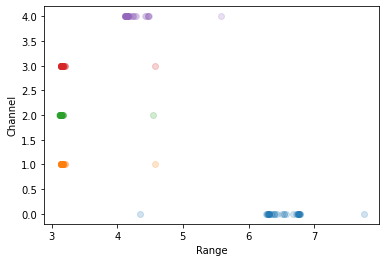

In [104]:
for i in range(ranges.shape[1]):
    plt.plot(ranges[:, i], np.zeros_like(ranges[:, i]) + i, 'o', alpha=0.2)
plt.xlabel('Range')
plt.ylabel('Channel')

In [105]:
# import seaborn as sns
# sns.histplot(ranges[:, 0], kde=True, stat="density", linewidth=0)

# Positions

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mp_patches  # For circles and rectangles

In [107]:
L = 9.5
W = 3.0
D = -3.5
dL = L / 6
h_locs = np.array((
    (dL * 2, W,   0.50),
    (dL * 4, 0,   1.50),
    (0, W/2,      1.0),
    (dL * 2, 0,   2.50),
    (dL * 4, W,   2.00),
))
h_locs[:, 2] *= -1

In [108]:
from scipy.optimize import minimize
def error(x, c, r):
    return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)

# Initial guess is weighted average (by distance) of station coordinates
x0 = (h_locs[None, :, :] * 1.0 / ranges[:, :, None]).sum(axis=1) / (1.0 / ranges[:, :, None]).sum(axis=1)
     
# optimize distance from signal origin to border of spheres
locs = np.empty((ranges.shape[0], h_locs.shape[1]))
for i, (xx0, ran) in enumerate(zip(x0, ranges)):
    locs[i] = minimize(error, xx0, args=(h_locs[:, :], ran), method='Nelder-Mead').x


(36, 3)

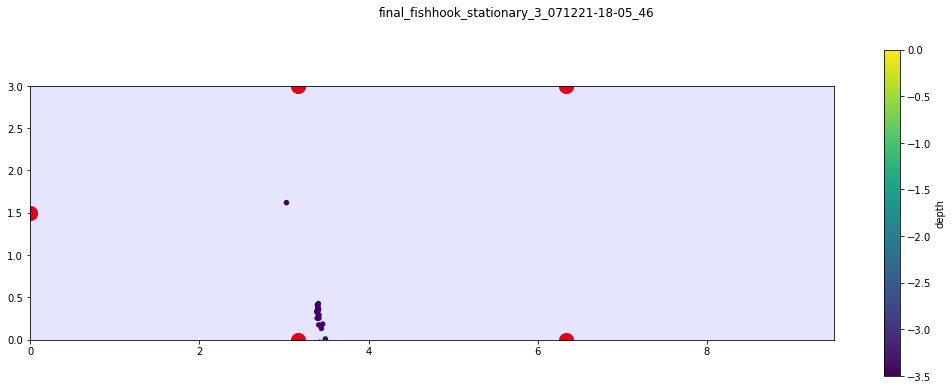

In [109]:
f, ax = plt.subplots(1,1, figsize=(18,6))

ax.set_aspect('equal', 'box')
ax.set_xlim(0, L)
ax.set_ylim(0, W)
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1, color='blue'))
ax.scatter(h_locs[:, 0], h_locs[:, 1], color='red', s=200)

plt.scatter(locs[:, 0], locs[:, 1], c=locs[:, 2], s=20, vmin=0, vmax=D)#, ax=ax)
plt.colorbar(label='depth')

f.suptitle(run)
locs.shape

In [110]:
locs

array([[ 3.41361375,  0.29120917, -4.5038439 ],
       [ 3.40372454,  0.37376572, -4.49272973],
       [ 3.02953924,  1.6192573 , -3.85486017],
       [ 3.42434463, -0.16590838, -4.49366955],
       [ 3.4388719 , -0.11565736, -4.50237239],
       [ 3.41370592,  0.2531053 , -4.51577593],
       [ 3.40674809,  0.35587396, -4.48950213],
       [ 3.40168748,  0.37243547, -4.48946933],
       [ 3.48818944, -0.07314236, -4.49721277],
       [ 3.44274075,  0.1318557 , -4.52017517],
       [ 3.41077373,  0.28754119, -4.49521998],
       [ 3.40912707,  0.35517863, -4.48602324],
       [ 3.48950221,  0.00681704, -4.50941694],
       [ 3.31993594, -0.44055483, -4.40282014],
       [ 3.41439872, -0.12511445, -4.51090715],
       [ 3.38982512,  0.33606474, -4.48265393],
       [ 3.39607818,  0.34155153, -4.48924062],
       [ 3.42177112, -0.03156851, -4.50778419],
       [ 3.39290467,  0.25298265, -4.50806862],
       [ 3.40543485,  0.35245139, -4.48959331],
       [ 3.49447224, -0.04011661, -4.500

In [ ]:
# %matplotlib notebook
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# ax.scatter(*locs.T)#, marker=m)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_xlim(0, L)
# ax.set_ylim(0, W)
# ax.set_zlim(D, 0)

# plt.show()

In [ ]:
%matplotlib inline

# Use Known Depth

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mp_patches  # For circles and rectangles

L = 9.5
W = 3.0
D = -3.5
dL = L / 6
h_locs = np.array((
    (dL * 2, W,   0.50),
    (dL * 4, 0,   1.50),
    (0, W/2,      1.0),
    (dL * 2, 0,   2.50),
    (dL * 4, W,   2.00),
))
h_locs[:, 2] *= -1

from scipy.optimize import minimize
def error(x, c, r):
    return np.sum((np.linalg.norm(x - c, axis=1) - r) ** 2)

# Initial guess is weighted average (by distance) of station coordinates
x0 = (h_locs[None, :, :2] * 1.0 / ranges[:, :, None]).sum(axis=1) / (1.0 / ranges[:, :, None]).sum(axis=1)
     
# optimize distance from signal origin to border of spheres
depth = -0.5
locs = np.empty((ranges.shape[0], h_locs.shape[1]))
for i, (xx0, ran) in enumerate(zip(x0, ranges)):
    locs[i, :2] = minimize(error, xx0, args=(h_locs[:, :2], np.sqrt(ran**2 - (h_locs[:, 2] - depth)**2)), method='Nelder-Mead').x

locs[:, 2] = depth

f, ax = plt.subplots(1,1, figsize=(18,6))

ax.set_aspect('equal', 'box')
ax.set_xlim(0, L)
ax.set_ylim(0, W)
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1, color='blue'))
ax.scatter(h_locs[:, 0], h_locs[:, 1], color='red', s=200)

# cs = [
#       ax.add_patch(mp_patches.Circle(hloc, r, fill=False, alpha=0.2, linewidth=5))
#       for hloc, r in zip(h_locs, range_2d[2]/3)
# ]

plt.scatter(locs[:, 0], locs[:, 1], c=locs[:, 2], s=20, vmin=0, vmax=D)#, ax=ax)
plt.colorbar(label='depth')

f.suptitle(run)
locs.shape

In [ ]:
win = slice(90,120)
f, ax = plt.subplots(1,1, figsize=(18,6))

ax.set_aspect('equal', 'box')
ax.set_xlim(0, L)
ax.set_ylim(0, W)
ax.add_patch(mp_patches.Rectangle((0, 0), L, W, alpha=0.1, color='blue'))
ax.scatter(h_locs[:, 0], h_locs[:, 1], color='red', s=200)

# cs = [
#       ax.add_patch(mp_patches.Circle(hloc, r, fill=False, alpha=0.2, linewidth=5))
#       for hloc, r in zip(h_locs, range_2d[2]/3)
# ]

plt.scatter(locs[win, 0], locs[win, 1], c=locs[win, 2], s=20, vmin=0, vmax=D)#, ax=ax)
plt.colorbar(label='depth')

f.suptitle(run)
locs.shape

# All Position Plots

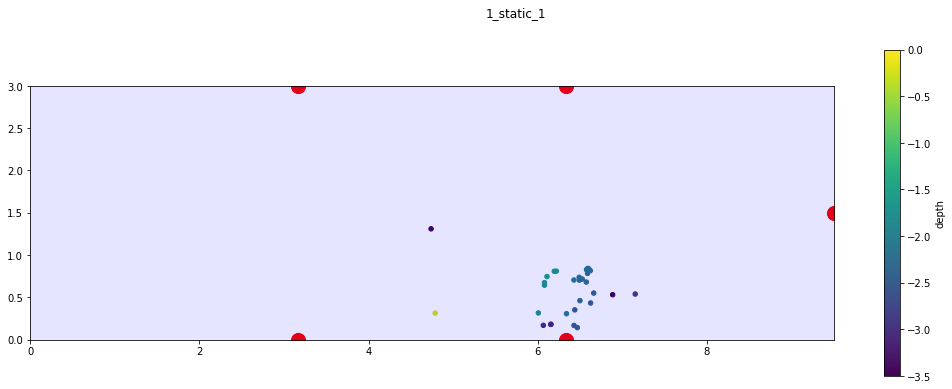

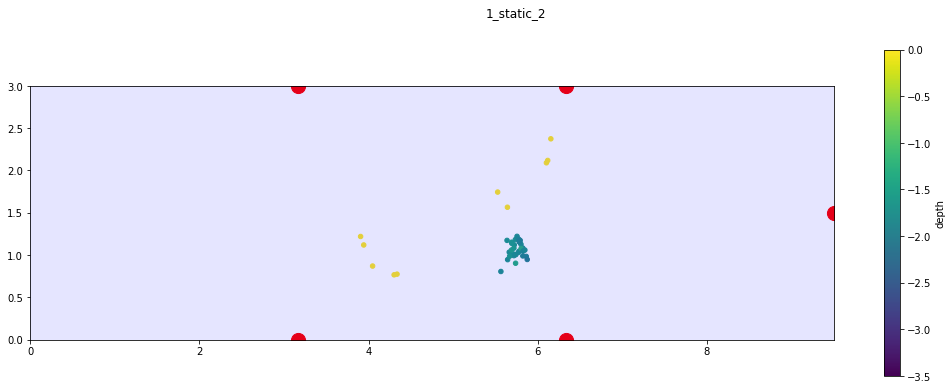

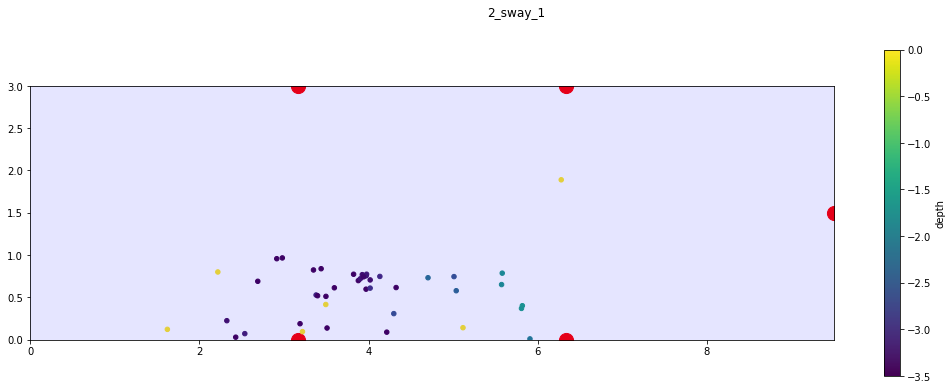

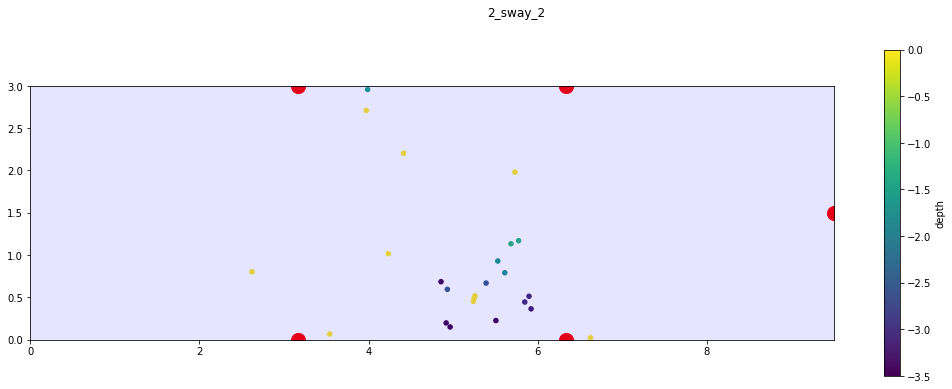

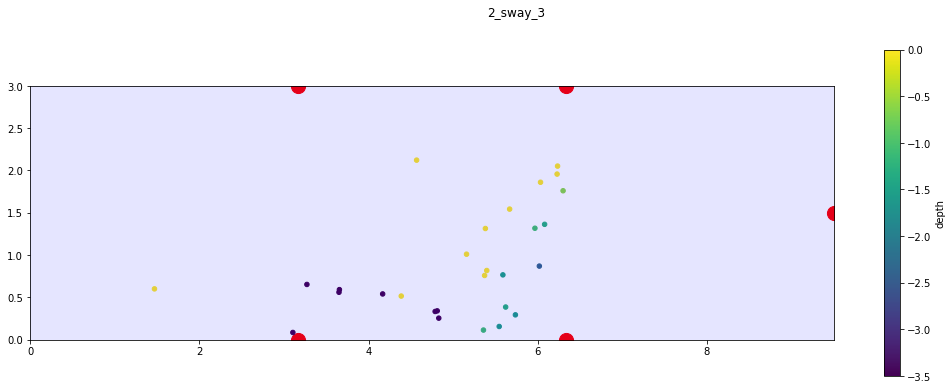

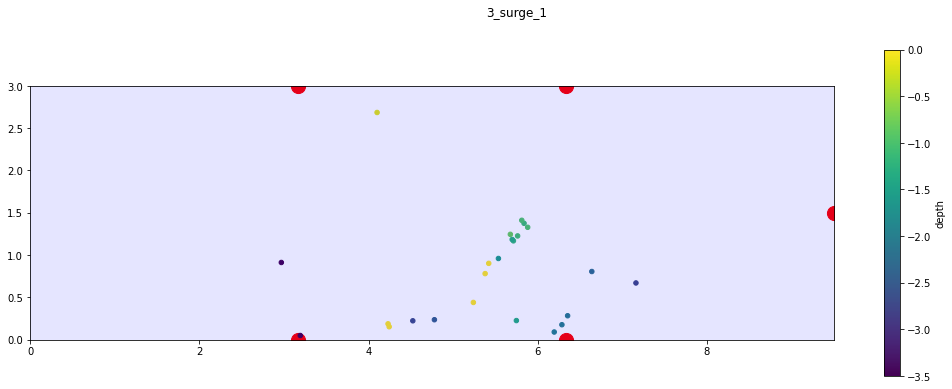

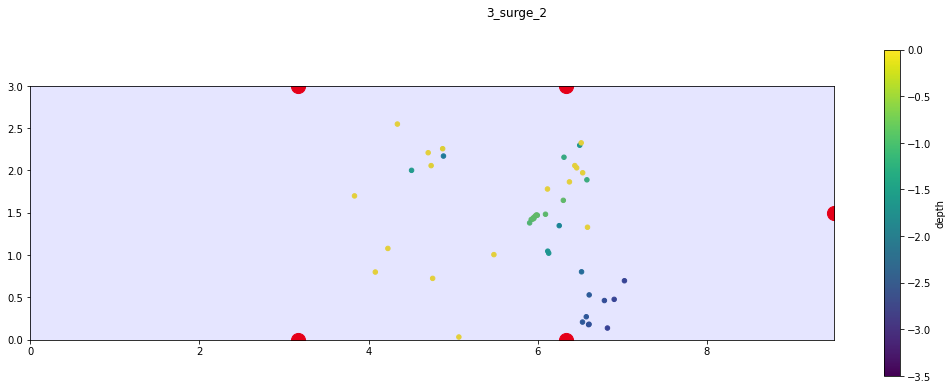

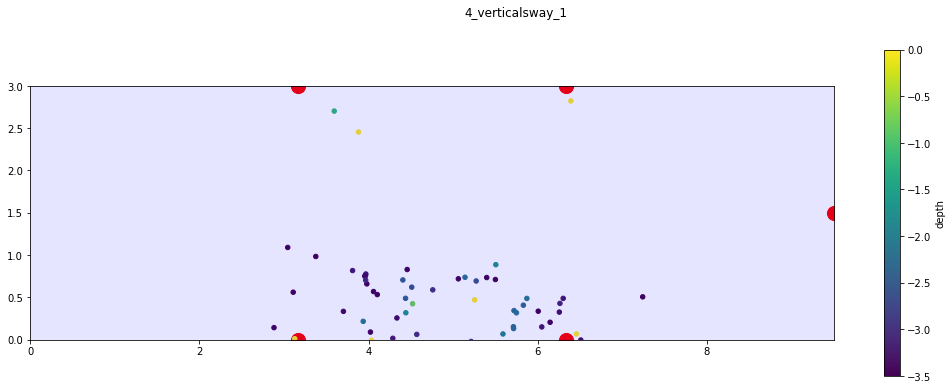

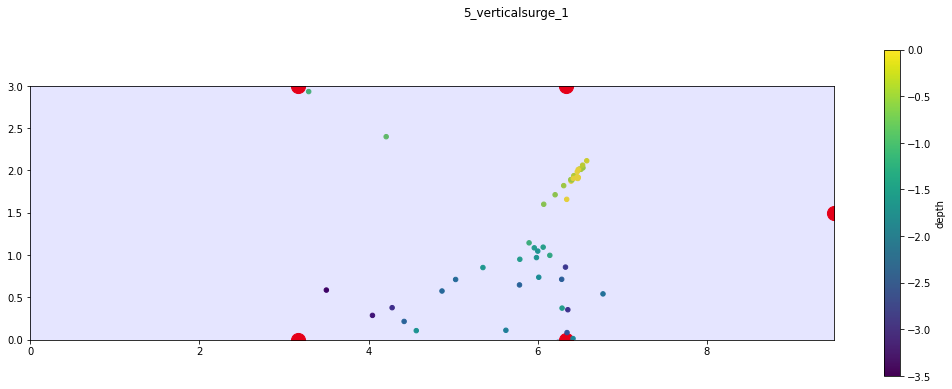

**The fifth hydrophone cupped here**
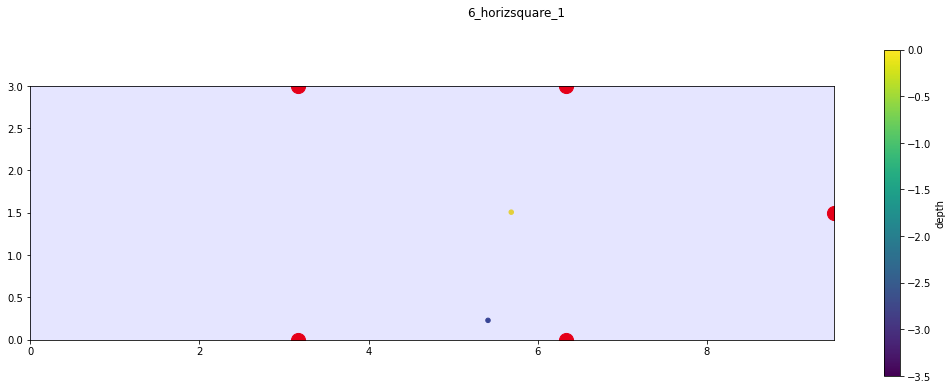

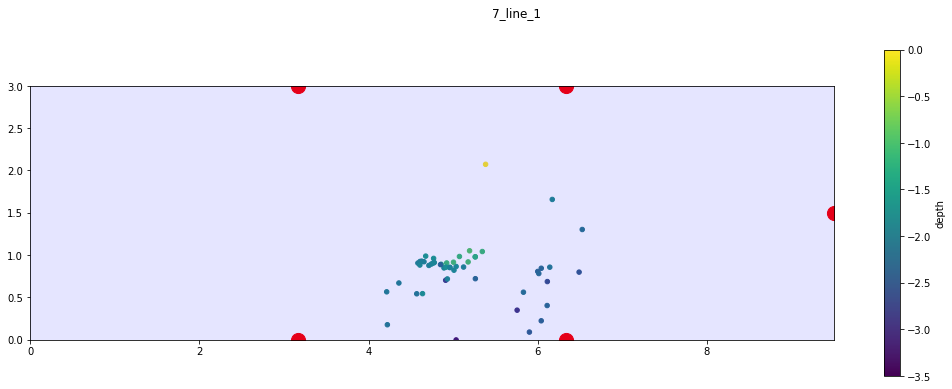